## Восстановление золота из руды
Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.  

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки.  

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.  

Вам нужно:  

Подготовить данные;  
Провести исследовательский анализ данных;  
Построить и обучить модель.  
Чтобы выполнить проект, обращайтесь к библиотекам pandas, matplotlib и sklearn. Вам поможет их документация.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (cross_val_score,train_test_split)
from sklearn.metrics import (make_scorer,mean_absolute_error)

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor


Откроем файлы и изучим данные

In [2]:
data_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv',index_col='date', parse_dates=True)
data_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv',index_col='date', parse_dates=True)
data_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv',index_col='date', parse_dates=True)

In [3]:
print(data_full.head())

                     final.output.concentrate_ag  final.output.concentrate_pb  \
date                                                                            
2016-01-15 00:00:00                     6.055403                     9.889648   
2016-01-15 01:00:00                     6.029369                     9.968944   
2016-01-15 02:00:00                     6.055926                    10.213995   
2016-01-15 03:00:00                     6.047977                     9.977019   
2016-01-15 04:00:00                     6.148599                    10.142511   

                     final.output.concentrate_sol  \
date                                                
2016-01-15 00:00:00                      5.507324   
2016-01-15 01:00:00                      5.257781   
2016-01-15 02:00:00                      5.383759   
2016-01-15 03:00:00                      4.858634   
2016-01-15 04:00:00                      4.939416   

                     final.output.concentrate_au  final.outp

In [4]:
data_full.info() #есть небольшие по количеству пропуск в данных

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                     

In [5]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 

In [6]:
print(data_full.shape)

(19439, 86)


In [7]:
print(data_test.shape)

(5290, 52)


Проверим, что эффективность обогащения рассчитана правильно.
Вычислим её на обучающей выборке для признака rougher.output.recovery. 
Найдем MAE между вашими расчётами и значением признака.

In [8]:
print(data_full['rougher.input.feed_au']) # доля золота в сырье до флотации F
print(data_full['rougher.output.concentrate_au']) # доля золота в концентрате после флотации C
print(data_full['rougher.output.tail_au']) # доля золота в отвальных хвостах после флотации T

date
2016-01-15 00:00:00    6.486150
2016-01-15 01:00:00    6.478583
2016-01-15 02:00:00    6.362222
2016-01-15 03:00:00    6.118189
2016-01-15 04:00:00    5.663707
                         ...   
2018-08-18 06:59:59    5.335862
2018-08-18 07:59:59    4.838619
2018-08-18 08:59:59    4.525061
2018-08-18 09:59:59    4.362781
2018-08-18 10:59:59    4.365491
Name: rougher.input.feed_au, Length: 19439, dtype: float64
date
2016-01-15 00:00:00    19.793808
2016-01-15 01:00:00    20.050975
2016-01-15 02:00:00    19.737170
2016-01-15 03:00:00    19.320810
2016-01-15 04:00:00    19.216101
                         ...    
2018-08-18 06:59:59    18.603550
2018-08-18 07:59:59    18.441436
2018-08-18 08:59:59    15.111231
2018-08-18 09:59:59    17.834772
2018-08-18 10:59:59    17.804134
Name: rougher.output.concentrate_au, Length: 19439, dtype: float64
date
2016-01-15 00:00:00    1.170244
2016-01-15 01:00:00    1.184827
2016-01-15 02:00:00    1.162562
2016-01-15 03:00:00    1.079755
2016-01-15 04:00

In [9]:
def rougher_output_recovery(data):
    rougher_output_recovery=((data['rougher.output.concentrate_au']*(data['rougher.input.feed_au']-data['rougher.output.tail_au']))/
                             (data['rougher.input.feed_au']*(data['rougher.output.concentrate_au']-data['rougher.output.tail_au']))*100)
    return rougher_output_recovery

In [10]:

rougher_recovery_calc_train=[]
rougher_recovery_calc_train.append(data_train.apply(rougher_output_recovery,axis=1))
rougher_recovery_calc_train=pd.Series(rougher_recovery_calc_train)
mae = mean_absolute_error(data_train['rougher.output.recovery'], rougher_recovery_calc_train[0])
print(mae)

9.73512347450521e-15


MAE получилось очень маленьким, что говорит о том,что расчеты эффективности обогащения  по формуле совпадают со значениями в обучающей выборке.

Посмотрим на признаки, которые отсутствуют в тестовой выборке.Эти признаки есть в обучающей выборке и в исходном датасете.  

In [11]:
diff=[]
diff=list(set(list(data_full.columns)).difference(list(data_test.columns)))
diff.remove('final.output.recovery') 
diff.remove('rougher.output.recovery') 
print(diff)

['primary_cleaner.output.concentrate_pb', 'final.output.concentrate_ag', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.tail_sol', 'final.output.concentrate_sol', 'rougher.output.concentrate_au', 'secondary_cleaner.output.tail_pb', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.output.tail_ag', 'final.output.tail_pb', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'final.output.tail_ag', 'primary_cleaner.output.tail_au', 'rougher.calculation.au_pb_ratio', 'secondary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_pb', 'final.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.tail_sol', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.output.tail_au', 'secondary_cleaner.output.tail_au', 'rougher.output.tail_pb', 'rougher.output.concentrate_ag', 'final.output.tail_sol', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_pb', '

В тестовой выборке отсутствуют параметры продукта, то есть выходные параметры. Также отсутствуют расчетные параметры.То есть эти параметры зависят от параметров сырья. Мне кажется это сделано умышленно, чтобы модель не подглядывала результат.

Удалим из обучающей выборки признаки, которых нет в тестовой выборке. 

In [12]:
print(diff)
data_train=data_train.drop(columns = diff) 
print(data_train.shape)

['primary_cleaner.output.concentrate_pb', 'final.output.concentrate_ag', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.tail_sol', 'final.output.concentrate_sol', 'rougher.output.concentrate_au', 'secondary_cleaner.output.tail_pb', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.output.tail_ag', 'final.output.tail_pb', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'final.output.tail_ag', 'primary_cleaner.output.tail_au', 'rougher.calculation.au_pb_ratio', 'secondary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_pb', 'final.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.tail_sol', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.output.tail_au', 'secondary_cleaner.output.tail_au', 'rougher.output.tail_pb', 'rougher.output.concentrate_ag', 'final.output.tail_sol', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_pb', '

Восстановим признаки в тестовой выборке с помощью исходного датасета. 

In [13]:

data_test = data_test.join(data_full[['final.output.recovery','rougher.output.recovery']])
print(data_test.shape)

(5290, 54)


Заполняем пропуски в данных

In [14]:
data_train = data_train.fillna(method="ffill")
data_test = data_test.fillna(method="ffill")
print(data_train.isna().sum())
print(data_test.isna().sum())

final.output.recovery                         0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

Text(0.5, 1.0, 'Концентрация серебра в руде')

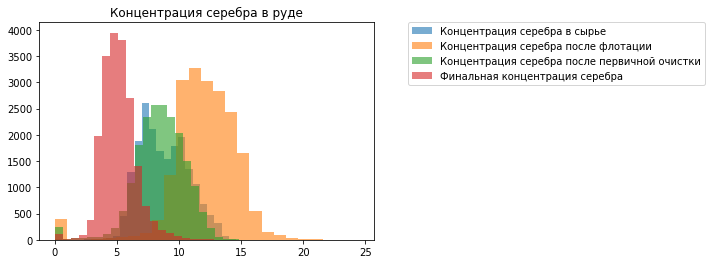

In [15]:
plt.hist(data_full['rougher.input.feed_ag'],label = 'Концентрация серебра в сырье',alpha=0.6,bins=25)
plt.hist(data_full['rougher.output.concentrate_ag'],label = 'Концентрация серебра после флотации',alpha=0.6,bins=25)
plt.hist(data_full['primary_cleaner.output.concentrate_ag'],label='Концентрация серебра после первичной очистки',alpha=0.6,bins=25)
plt.hist(data_full['final.output.concentrate_ag'],label = 'Финальная концентрация серебра',alpha=0.6,bins=25)   
plt.legend(bbox_to_anchor=( 1.1 , 1 ), loc='upper left', borderaxespad= 0 )
plt.title('Концентрация серебра в руде')


После прохождения флотации и очистки в руде упала концентрация серебра.

Text(0.5, 1.0, 'Концентрация золота в руде')

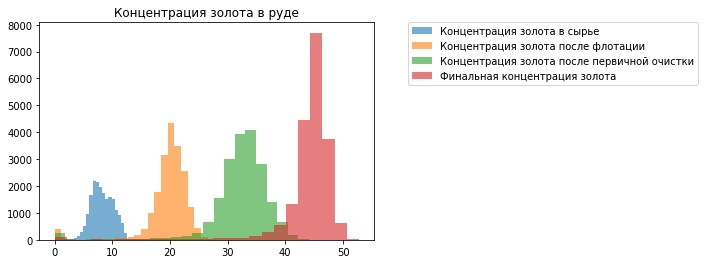

In [16]:
plt.hist(data_full['rougher.input.feed_au'],label = 'Концентрация золота в сырье',alpha=0.6,bins=25)
plt.hist(data_full['rougher.output.concentrate_au'],label = 'Концентрация золота после флотации',alpha=0.6,bins=25)
plt.hist(data_full['primary_cleaner.output.concentrate_au'],label='Концентрация золота после первичной очистки',alpha=0.6,bins=25)
plt.hist(data_full['final.output.concentrate_au'],label = 'Финальная концентрация золота',alpha=0.6,bins=25)   
plt.legend(bbox_to_anchor=( 1.1 , 1 ), loc='upper left', borderaxespad= 0 )
plt.title('Концентрация золота в руде')

После прохождения флотации и очистки в руде увеличилась концентрация золота, что и является сутью процесса.

Text(0.5, 1.0, 'Концентрация свинца в руде')

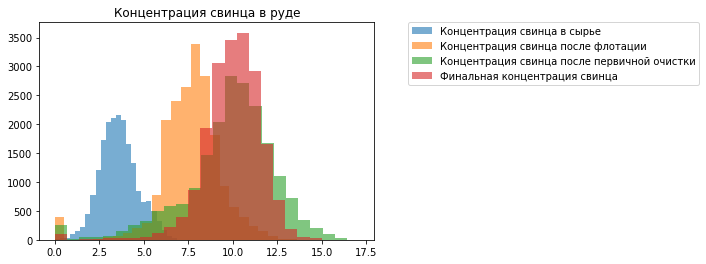

In [17]:
plt.hist(data_full['rougher.input.feed_pb'],label = 'Концентрация свинца в сырье',alpha=0.6,bins=25)
plt.hist(data_full['rougher.output.concentrate_pb'],label = 'Концентрация свинца после флотации',alpha=0.6,bins=25)
plt.hist(data_full['primary_cleaner.output.concentrate_pb'],label='Концентрация свинца после первичной очистки',alpha=0.6,bins=25)
plt.hist(data_full['final.output.concentrate_pb'],label = 'Финальная концентрация свинца',alpha=0.6,bins=25)   
plt.legend(bbox_to_anchor=( 1.1 , 1 ), loc='upper left', borderaxespad= 0 )
plt.title('Концентрация свинца в руде')

Как видим на графике, что после первичной очистки концентрация свинца в руде выросла, а после финальной очистки почти не изменилась.
Зато после финальной очистки разброс значений концентрации свинца небольшой, значит концетрация свинца уже имеет более предсказуемое значение.


Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

(0.0, 120.0)

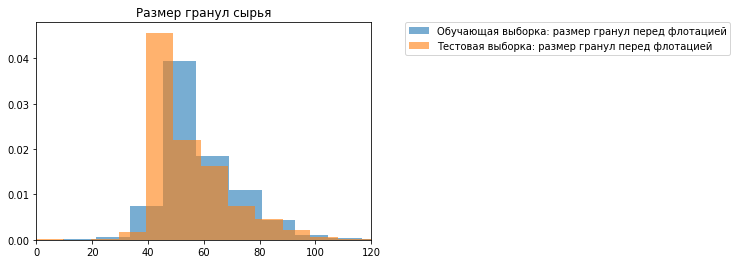

In [18]:
plt.hist(data_train['rougher.input.feed_size'],label='Обучающая выборка: размер гранул перед флотацией',bins=40,density=True,alpha=0.6)
plt.hist(data_test['rougher.input.feed_size'],label='Тестовая выборка: размер гранул перед флотацией',bins=40,density=True,alpha=0.6)
plt.legend(bbox_to_anchor=( 1.1 , 1 ), loc='upper left', borderaxespad= 0 )
plt.title('Размер гранул сырья')
plt.xlim(0,120)

(5.0, 10.0)

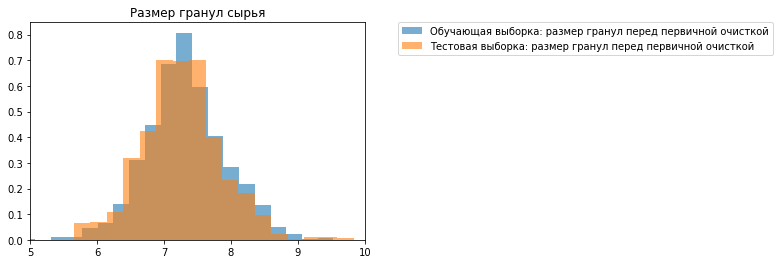

In [19]:
plt.hist(data_train['primary_cleaner.input.feed_size'],label='Обучающая выборка: размер гранул перед первичной очисткой',bins=40,density=True,alpha=0.6)
plt.hist(data_test['primary_cleaner.input.feed_size'],label='Тестовая выборка: размер гранул перед первичной очисткой',bins=40,density=True,alpha=0.6)
plt.legend(bbox_to_anchor=( 1.1 , 1 ), loc='upper left', borderaxespad= 0 )
plt.title('Размер гранул сырья')
plt.xlim(5,10)

Как видно на графиках, 
распределение размера гранул (перед флотацией и перед первичной очисткой) на обучающей и на тестовой выборках очень похожи.  
Значит у модели не должно быть проблем с обучением. 

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

Text(0.5, 1.0, 'Суммарная концентрация всех веществ в сырье')

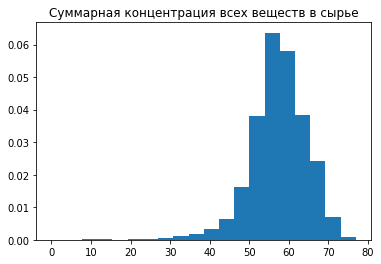

In [20]:
rougher_input_concentrate=data_full['rougher.input.feed_ag']+data_full['rougher.input.feed_pb']+data_full['rougher.input.feed_au']+data_full['rougher.input.feed_sol']
plt.hist(rougher_input_concentrate,bins=20,density=True)
plt.title('Суммарная концентрация всех веществ в сырье')

Text(0.5, 1.0, 'Суммарная концентрация всех веществ после флотации')

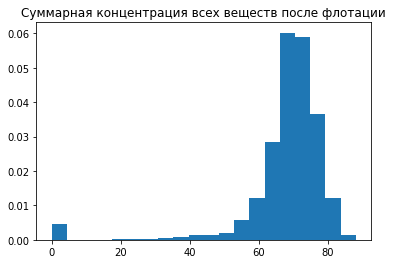

In [21]:
rougher_output_concentrate=data_full['rougher.output.concentrate_ag']+data_full['rougher.output.concentrate_pb']+data_full['rougher.output.concentrate_au']+data_full['rougher.output.concentrate_sol']
plt.hist(rougher_output_concentrate,bins=20,density=True)
plt.title('Суммарная концентрация всех веществ после флотации')

Text(0.5, 1.0, 'Суммарная концентрация всех веществ в черновом концентрате')

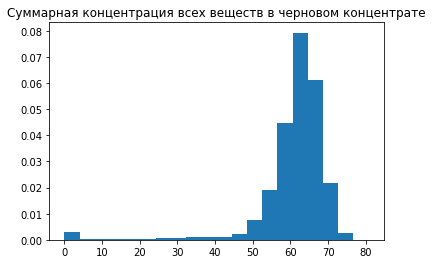

In [22]:
primary_cleaner_output_concentrate=data_full['primary_cleaner.output.concentrate_ag']+data_full['primary_cleaner.output.concentrate_pb']+data_full['primary_cleaner.output.concentrate_au']+data_full['primary_cleaner.output.concentrate_sol']
plt.hist(primary_cleaner_output_concentrate,bins=20,density=True)
plt.title('Суммарная концентрация всех веществ в черновом концентрате')

Text(0.5, 1.0, 'Суммарная концентрация всех веществ в финальном концентрате')

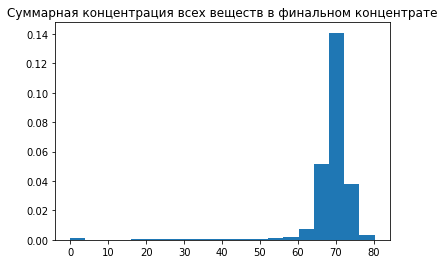

In [23]:
final_output_concentrate=data_full['final.output.concentrate_ag']+data_full['final.output.concentrate_pb']+data_full['final.output.concentrate_au']+data_full['final.output.concentrate_sol']
plt.hist(final_output_concentrate,bins=20,density=True)
plt.title('Суммарная концентрация всех веществ в финальном концентрате')

Концентрация веществ (свинец, золото, серебро) от стадии к стадии растет.   
То есть концентрация веществ в черновом концентрате выше чем, в сырье.  
Концентрация веществ в финальном концентрате выше, чем в черновом концентрате. 


Обработка выбросов

Посмотрим на выбросы в финальном концентрате и после флотации. 

In [24]:
data_train = data_train.join(data_full[['final.output.concentrate_ag','final.output.concentrate_pb','final.output.concentrate_au','final.output.concentrate_sol']])
data_train['final_output_concentrate_sum']=data_train['final.output.concentrate_ag']+data_train['final.output.concentrate_pb']+data_train['final.output.concentrate_au']+data_train['final.output.concentrate_sol']


array([[<AxesSubplot:title={'center':'final_output_concentrate_sum'}>]],
      dtype=object)

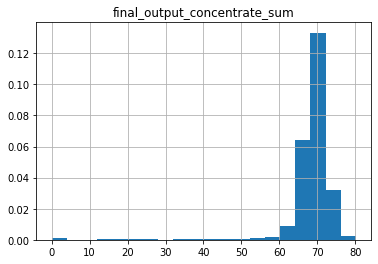

In [25]:
data_train[['final_output_concentrate_sum']].hist(bins=20,density=True)

In [26]:
data_train=data_train[data_train['final_output_concentrate_sum']!=0]

In [27]:
data_train = data_train.join(data_full[['rougher.output.concentrate_ag','rougher.output.concentrate_pb','rougher.output.concentrate_au','rougher.output.concentrate_sol']])
data_train['rougher_output_concentrate_sum']=data_train['rougher.output.concentrate_ag']+data_train['rougher.output.concentrate_pb']+data_train['rougher.output.concentrate_au']+data_train['rougher.output.concentrate_sol']

array([[<AxesSubplot:title={'center':'rougher_output_concentrate_sum'}>]],
      dtype=object)

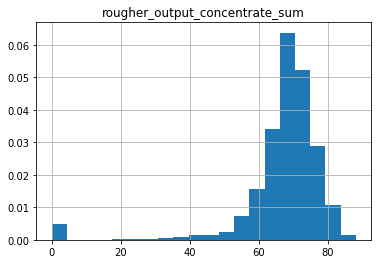

In [28]:
data_train[['rougher_output_concentrate_sum']].hist(bins=20,density=True)

In [29]:
data_train=data_train[data_train['rougher_output_concentrate_sum']!=0]

In [30]:
list_columns=['rougher_output_concentrate_sum','final_output_concentrate_sum','rougher.output.concentrate_ag','rougher.output.concentrate_pb','rougher.output.concentrate_au','rougher.output.concentrate_sol','final.output.concentrate_ag','final.output.concentrate_pb','final.output.concentrate_au','final.output.concentrate_sol']

In [31]:
data_train = data_train.drop(list_columns,axis=1)

In [32]:
#избавляемся от индекса date
data_test=data_test.reset_index(drop= True)
data_train=data_train.reset_index(drop= True)


Масшатабирование признаков

In [35]:

features_train = data_train.drop(['rougher.output.recovery','final.output.recovery'],axis=1)
target_train=data_train[['rougher.output.recovery','final.output.recovery']]
scaler = StandardScaler()
scaler.fit(features_train) 

features_test = data_test.drop(['rougher.output.recovery','final.output.recovery'],axis=1)
target_test=data_test[['rougher.output.recovery','final.output.recovery']]


features_train= scaler.transform(features_train)
features_test = scaler.transform(features_test) 



Рассмотрим матрицу корреляции на предмет наличия высокой степени корреляции между каким-либо признаком и целевыми признаками.

In [36]:
pd.set_option('display.max_rows', 60)
data_corr=data_train.corr()
corr_rougher_output_recovery=data_corr['rougher.output.recovery']>0.9
corr_final_output_recovery=data_corr['final.output.recovery']>0.9
print("Высокая корреляция rougher_output_recovery с ", np.sum(corr_rougher_output_recovery==True)-1,'признаками') #корреляция признака сам с собой всегда равна 1, поэтому вычитаем 1
print("Высокая корреляция final_output_recovery с ",np.sum(corr_final_output_recovery==True)-1,'признаками')

у нас нет сильной корреляции между каким-либо из признаков и целевым признаком.

Создадим функцию для расчета метрики sMAPE

In [37]:
def sMAPE(target, predict):
    smape_rougher_output_recovery =  100/len(target['rougher.output.recovery']) * np.sum(2 * np.abs(predict[:,0] - target['rougher.output.recovery']) / (np.abs(target['rougher.output.recovery']) + np.abs(predict[:,0])))
    smape_final_output_recovery =  100/len(target['final.output.recovery']) * np.sum(2 * np.abs(predict[:,1] - target['final.output.recovery']) / (np.abs(target['final.output.recovery']) + np.abs(predict[:,1])))
    return (0.25*smape_rougher_output_recovery + 0.75*smape_final_output_recovery)


Обучим модели

Решающее дерево

In [38]:

features =  data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target = data_train[['rougher.output.recovery', 'final.output.recovery']]

In [39]:

best_model = None
best_result = 20
best_depth = 0


for depth in range(1, 10):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth) 
    smape_score = make_scorer(sMAPE, greater_is_better=False)
    results = cross_val_score(model,features, target,  cv=5, scoring=smape_score)
    result = - results.mean()
    #print(results, result)
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth
best_depth_1=best_depth
print("sMAPE наилучшей модели решающего дерева:", round(best_result,2), "Глубина дерева:", best_depth_1)

Линейная регрессия

In [40]:

model = LinearRegression()
smape_score = make_scorer(sMAPE, greater_is_better=False)
scores = cross_val_score(model,features, target,  cv=5, scoring=smape_score)
score = - scores.mean()
print("sMAPE модели линейной регрессии:", round(score,2))


Случайный лес

In [41]:
best_model = None
best_result = 20
best_est = 0
best_depth = 0
for est in range(1, 11):
    for depth in range (1, 11):
        model = RandomForestRegressor(random_state=12345, max_depth=depth,n_estimators=est) 
        smape_score = make_scorer(sMAPE, greater_is_better=False)
        results = cross_val_score(model,features, target,  cv=5, scoring=smape_score)
        result = - results.mean()
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
print("sMAPE наилучшей модели случайного леса:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

Качество модели случайного леса немного лучше, чем решающего дерева. Но случайный лес проигрывает по скорости.  
Считаем, что наилучшая модель - решающее дерево.  

Проверим качество модели на тестовой выборке

In [42]:
features_train = data_train.drop(['rougher.output.recovery','final.output.recovery'],axis=1)
target_train=data_train[['rougher.output.recovery','final.output.recovery']]

features_test = data_test.drop(['rougher.output.recovery','final.output.recovery'],axis=1)
target_test=data_test[['rougher.output.recovery','final.output.recovery']]

model = DecisionTreeRegressor(random_state=12345, max_depth=best_depth_1) 
model.fit(features_train, target_train)
predicted_test=model.predict(features_test)
smape_score = sMAPE(target_test,predicted_test)


print("sMAPE модели решающего дерева на тестовых данных:", round(smape_score,2), "Глубина дерева:", best_depth_1)

Сравним качество модели с dummy моделью

In [43]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
predicted_test = dummy_regr.predict(features_test)
result = sMAPE (target_test, predicted_test)
print("sMAPE dummy модели:", round(result,2))


Модель прошла проверку на адекватность, качество нашей модели решающего дерева выше чем константной модели.

Общий вывод:  
В результате анализа можно сделать следующие выводы:  
После прохождения флотации и очистки в руде упала концентрация серебра.    
После прохождения флотации и очистки в руде увеличилась концентрация золота, что и является сутью процесса.     
Обучили разные модели, предсказыващие эффективность обогащения чернового и финального концентрата.  
Вычислили метрику sMAPE.Проверили качество кросс-валидацией.    
В результате была выбрана модель решающего дерева.   
Сравнили качество модели с константной моделью.      
sMAPE модели решающего дерева: 9.32.Глубина дерева: 1   
